In [87]:
from fredapi import Fred
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from functools import reduce
from dataprep.eda import plot, plot_correlation, create_report

plt.style.use('ggplot')

In [8]:
# Load environment variables from .env file
load_dotenv()

api_key = os.getenv('FRED_API_KEY')

# Create the FRED Object
fred = Fred(api_key= api_key)

## Functions calling

In [9]:
def load_and_process_seasonal_data(data_fetcher, series_id, value_column, start_date='2018-01-01', 
                          resample_frequency='D', seasonal=7):
    """
    Loads and processes time series data from a given data source, handles missing values, 
    resamples to a given frequency, and applies STL decomposition.

    Parameters:
    - data_fetcher: Function to fetch the time series data (e.g., fred.get_series)
    - series_id: Identifier for the series to fetch (e.g., 'SP500')
    - value_column: Desired name for the value column in the output DataFrame
    - start_date: The start date for filtering the data
    - resample_frequency: The frequency to which the data should be resampled (e.g., 'D' for daily)
    - seasonal: Seasonal period for STL decomposition

    Returns:
    - A tuple of DataFrames: the resampled original and the seasonally adjusted data
    """
    # Fetch the time series data and set the column name
    series_data = data_fetcher(series_id)
    series_data.name = value_column
    df = series_data.to_frame().reset_index()

    # Convert the date column to datetime, set as index, and filter the data
    df['index'] = pd.to_datetime(df['index'])
    df = df.set_index('index')
    df = df[df.index >= start_date]

    # Resample and interpolate the data to handle missing values
    df_resampled = df.resample(resample_frequency).mean()
    df_resampled[value_column] = df_resampled[value_column].bfill().interpolate(method='linear')

    # Apply STL decomposition to extract the trend component
    stl = STL(df_resampled[value_column], seasonal=seasonal, robust=True)
    result = stl.fit()

    # Extract the seasonally adjusted series and convert to DataFrame
    df_adjusted = result.trend.to_frame(name=f'{value_column}_adjusted')

    return df_resampled.reset_index(), df_adjusted.reset_index()

In [10]:
def process_time_series_data(df, date_column='Date', value_column='Value', start_date='2018-01-01', resample_frequency='D', interpolate_method='linear'):
    """
    Processes time series data by filtering, cleaning, and resampling.

    Parameters:
    - df: DataFrame containing the time series data.
    - date_column: The column name in the DataFrame that contains the date information.
    - value_column: The column name in the DataFrame that contains the value to process.
    - start_date: The start date for filtering the data.
    - resample_frequency: The frequency to which the data should be resampled.
    - interpolate_method: The method used for interpolation during resampling.

    Returns:
    - A DataFrame with processed time series data.
    """
    # Convert date column to datetime and set as index
    df[date_column] = pd.to_datetime(df[date_column])
    df.set_index(date_column, inplace=True)

    # Filter based on start date and drop rows with missing target values
    filtered_df = df[df.index >= start_date].dropna(subset=[value_column])

    # Resample and interpolate the data
    resampled_df = filtered_df.resample(resample_frequency).interpolate(method=interpolate_method)

    # Reset the index to turn the date index back into a column
    return resampled_df.reset_index()

# Exploratory Data Analysis (EDA)

## Univariate Analysis

### Custom EDA Functions

In [11]:
def plot_time_series_plotly(df, x_column, y_column, title):
    """
    Plots a time series line chart using Plotly Express.

    Parameters:
    df (DataFrame): The DataFrame containing the data.
    x_column (str): The name of the column to be used for the x-axis.
    y_column (str): The name of the column to be used for the y-axis.
    title (str): The title of the plot.
    """
    # Convert the x_column to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(df[x_column]):
        df[x_column] = pd.to_datetime(df[x_column])

    # Create the plot using Plotly Express
    fig = px.line(df, x=x_column, y=y_column, title=title)

    # Improve the layout of the plot
    fig.update_layout(
        xaxis_title="Date",
        yaxis_title=y_column,
        plot_bgcolor='white',
        xaxis_showgrid=False,
        yaxis_showgrid=True,
        yaxis_gridcolor='lightgrey'
    )

    # Show the plot
    fig.show()

In [12]:
# Define a function to plot time series
def plot_time_series(data, column, title, ylabel, color='blue'):
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data[column], label=column, color = color)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel(ylabel)
    plt.grid(color='white', linestyle='-', linewidth=0.5)
    plt.legend()
    plt.show()

In [13]:
def plot_with_anomalies(data, column, title, ylabel):
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data[column], label=column, color = 'green')

    # Simple method to find anomalies: using z-score (mean and std deviation)
    # Considering values far from mean as potential anomalies
    threshold = 3  # typically 3 or more standard deviations from the mean
    mean_val = data[column].mean()
    std_dev = data[column].std()
    anomalies = data[(data[column] > mean_val + threshold * std_dev) | (data[column] < mean_val - threshold * std_dev)]

    # Highlight anomalies
    if not anomalies.empty:
        plt.scatter(anomalies.index, anomalies[column], color='red', label='Anomaly')
    
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    plt.show()

### S&P 500

In [14]:
sp500_processed, sp500_adjusted = load_and_process_seasonal_data(fred.get_series, 'SP500', 'sp500')

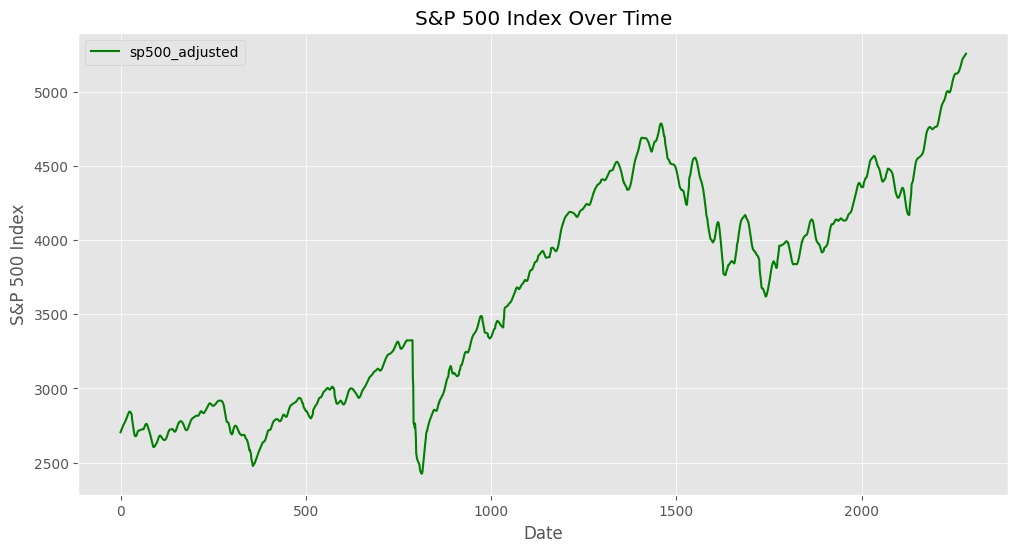

In [15]:
plot_time_series(sp500_adjusted, 'sp500_adjusted', 'S&P 500 Index Over Time', 'S&P 500 Index', color='green')

In [90]:
plot_time_series_plotly(sp500_adjusted, 'index', 'sp500_adjusted', 'S&P 500 Index Over Time')

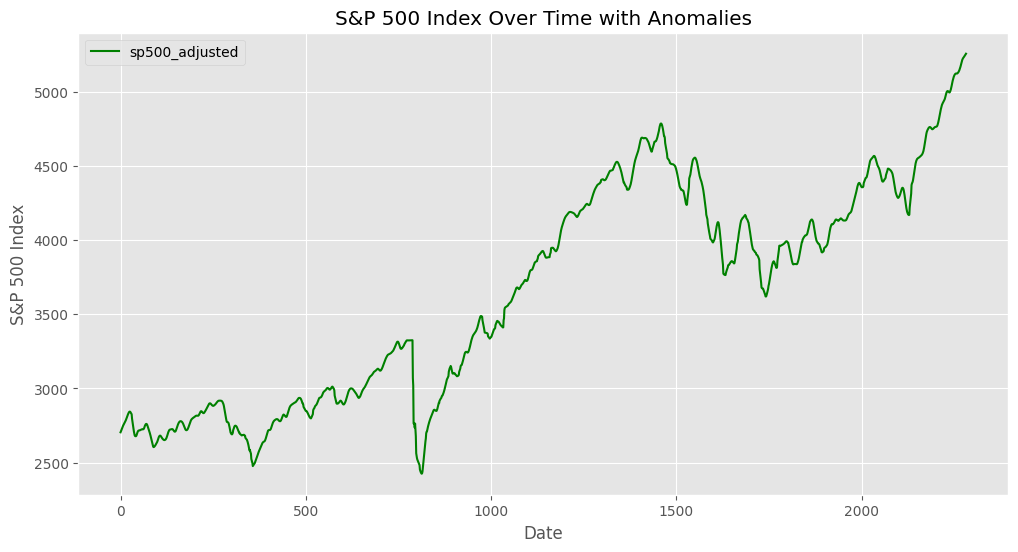

In [17]:
plot_with_anomalies(sp500_adjusted, 'sp500_adjusted', 'S&P 500 Index Over Time with Anomalies', 'S&P 500 Index')

In [91]:
# plot(sp500_adjusted, 'sp500_adjusted')

### GDP

In [21]:
gdp_df = fred.get_series('GDP').to_frame('gdp').reset_index()
processed_gdp = process_time_series_data(gdp_df, date_column='index', value_column='gdp')

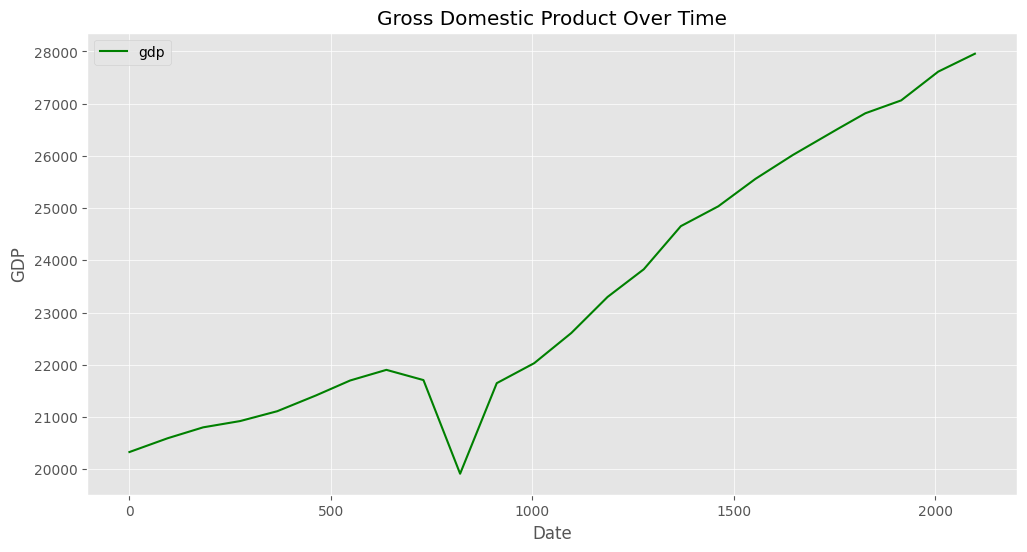

In [22]:
plot_time_series(processed_gdp, 'gdp', 'Gross Domestic Product Over Time', 'GDP', color = 'green')

In [92]:
plot_time_series_plotly(processed_gdp, 'index', 'gdp', 'Gross Domestic Product Over Time')

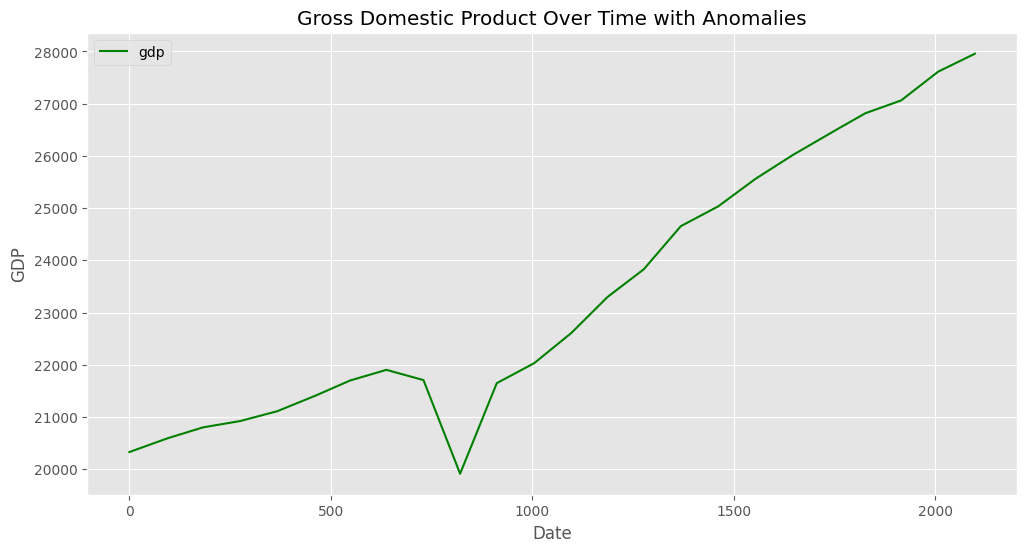

In [24]:
plot_with_anomalies(processed_gdp, 'gdp', 'Gross Domestic Product Over Time with Anomalies', 'GDP')

In [93]:
# plot(processed_gdp, 'gdp')

### Real GDP

In [26]:
real_gdp_df = fred.get_series('GDPC1').to_frame('rgdp').reset_index()
processed_real_gdp = process_time_series_data(real_gdp_df, date_column='index', value_column='rgdp')

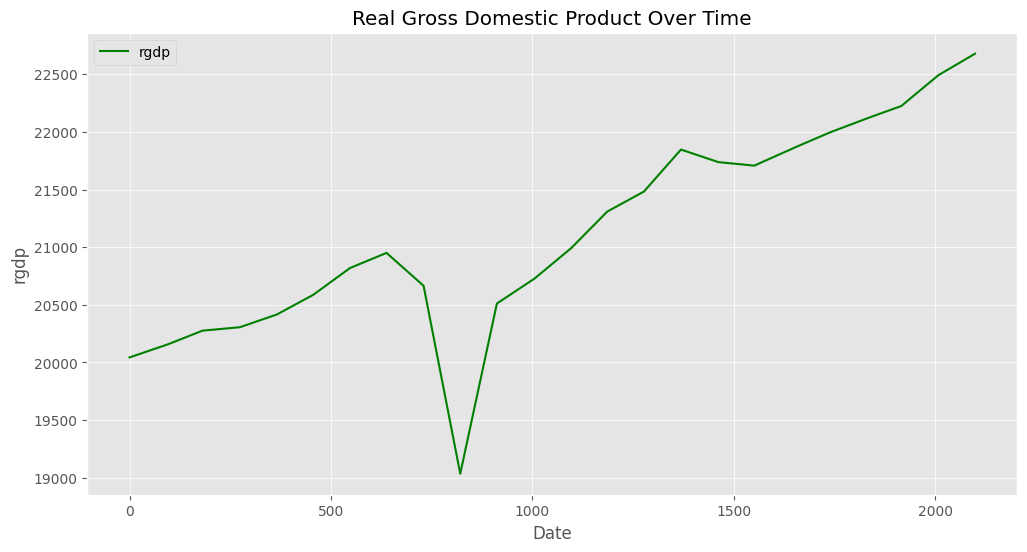

In [27]:
plot_time_series(processed_real_gdp, 'rgdp', 'Real Gross Domestic Product Over Time', 'rgdp', color = 'green')

In [94]:
plot_time_series_plotly(processed_real_gdp, 'index', 'rgdp', 'Real Gross Domestic Product Over Time')

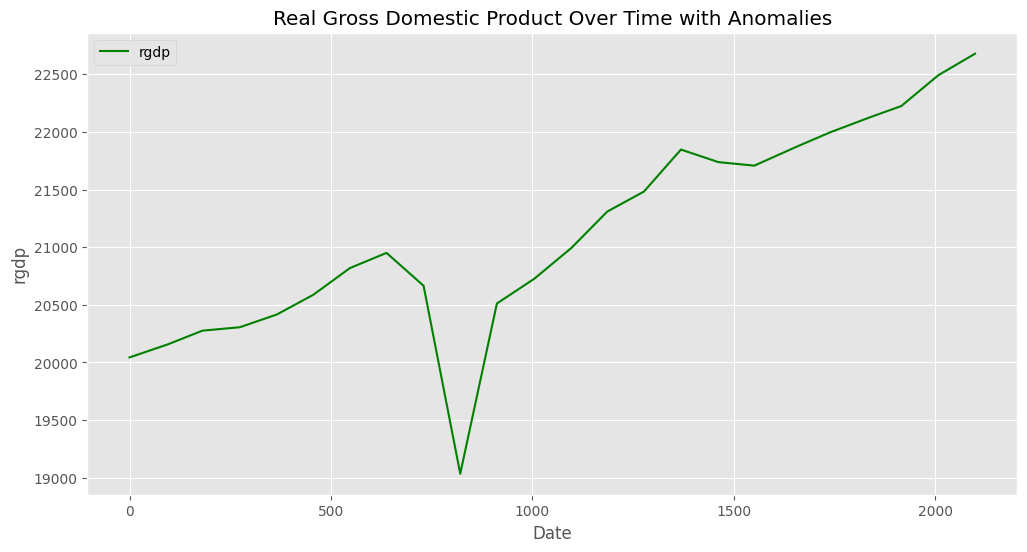

In [29]:
plot_with_anomalies(processed_real_gdp, 'rgdp', 'Real Gross Domestic Product Over Time with Anomalies', 'rgdp')

In [95]:
# plot(processed_real_gdp, 'rgdp')

### Unemployment Rate

In [31]:
unrate_df = fred.get_series('UNRATE').to_frame('unrate').reset_index()
processed_unrate_df = process_time_series_data(unrate_df, date_column='index', value_column='unrate')

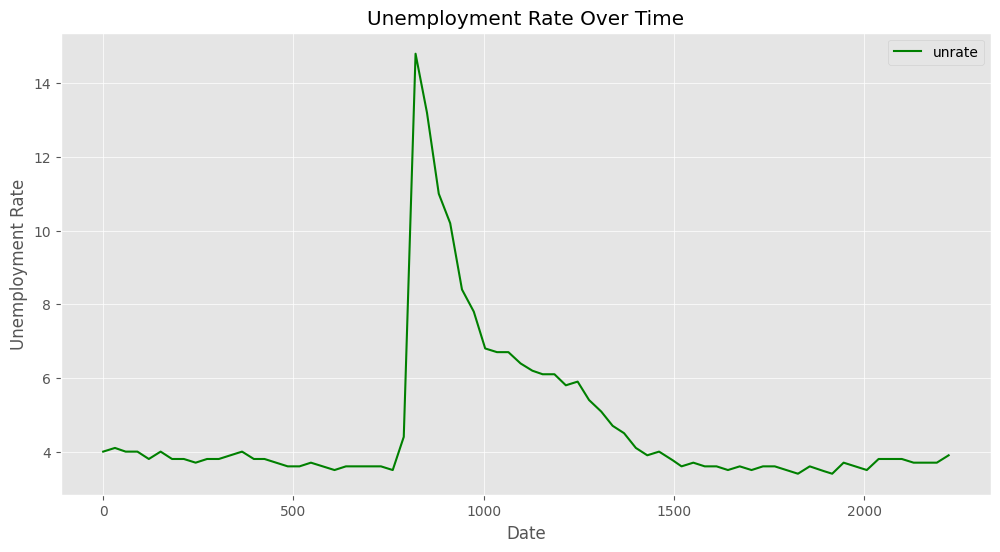

In [32]:
plot_time_series(processed_unrate_df, 'unrate', 'Unemployment Rate Over Time', 'Unemployment Rate', color = 'green')

In [96]:
plot_time_series_plotly(processed_unrate_df, 'index', 'unrate', 'Unemployment Rate Over Time')

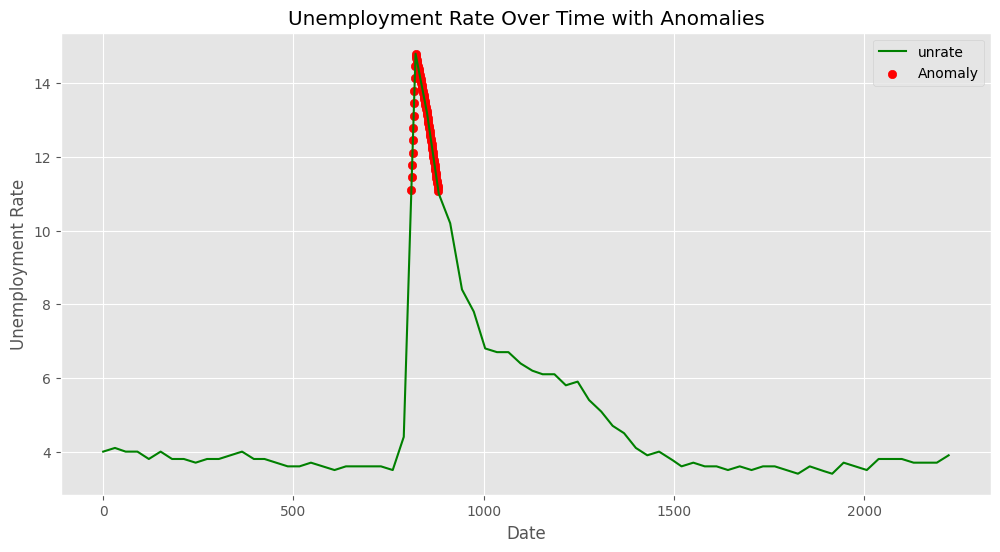

In [34]:
plot_with_anomalies(processed_unrate_df, 'unrate', 'Unemployment Rate Over Time with Anomalies', 'Unemployment Rate')

In [97]:
# plot(processed_unrate_df, 'unrate')

### CPI

In [36]:
cpi_df = fred.get_series('CPIAUCSL').to_frame('cpi').reset_index()
processed_cpi_df = process_time_series_data(cpi_df, date_column='index', value_column='cpi')

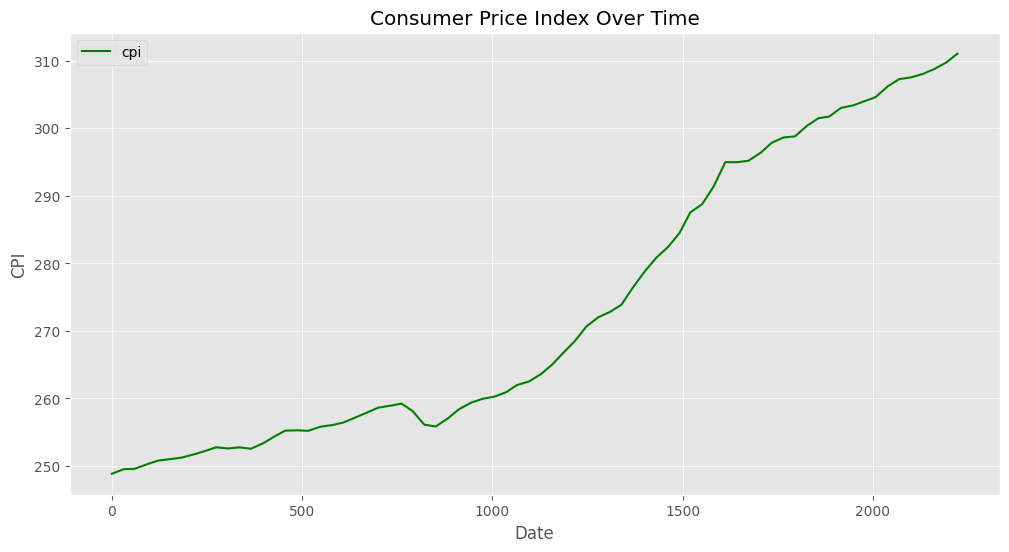

In [37]:
plot_time_series(processed_cpi_df, 'cpi', 'Consumer Price Index Over Time', 'CPI', color = 'green')

In [98]:
plot_time_series_plotly(processed_cpi_df, 'index', 'cpi', 'Consumer Price Index Over Time')

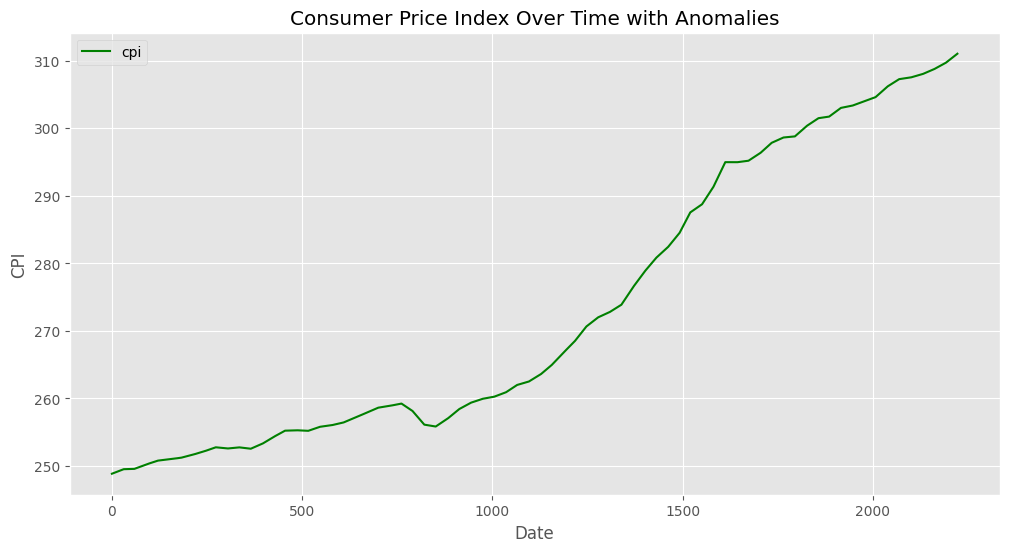

In [39]:
plot_with_anomalies(processed_cpi_df, 'cpi', 'Consumer Price Index Over Time with Anomalies', 'CPI')

In [99]:
# plot(processed_cpi_df, 'cpi')

### Interest Rate

In [41]:
int_rate_processed, int_rate_adjusted = load_and_process_seasonal_data(fred.get_series, 'REAINTRATREARAT10Y', 'interest_rate')

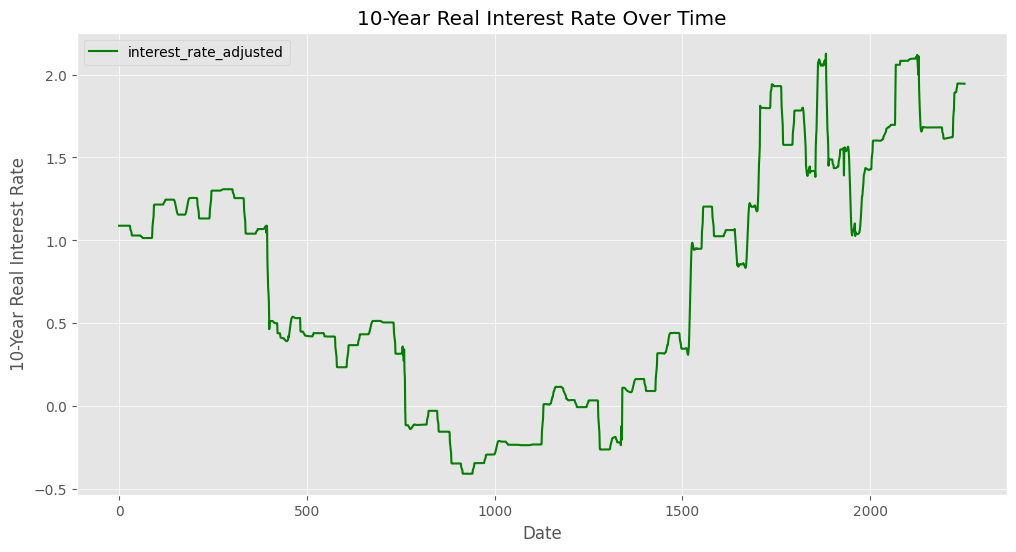

In [42]:
plot_time_series(int_rate_adjusted, 'interest_rate_adjusted', '10-Year Real Interest Rate Over Time', '10-Year Real Interest Rate', color='green')

In [100]:
plot_time_series_plotly(int_rate_adjusted, 'index', 'interest_rate_adjusted', '10-Year Real Interest Rate Over Time')

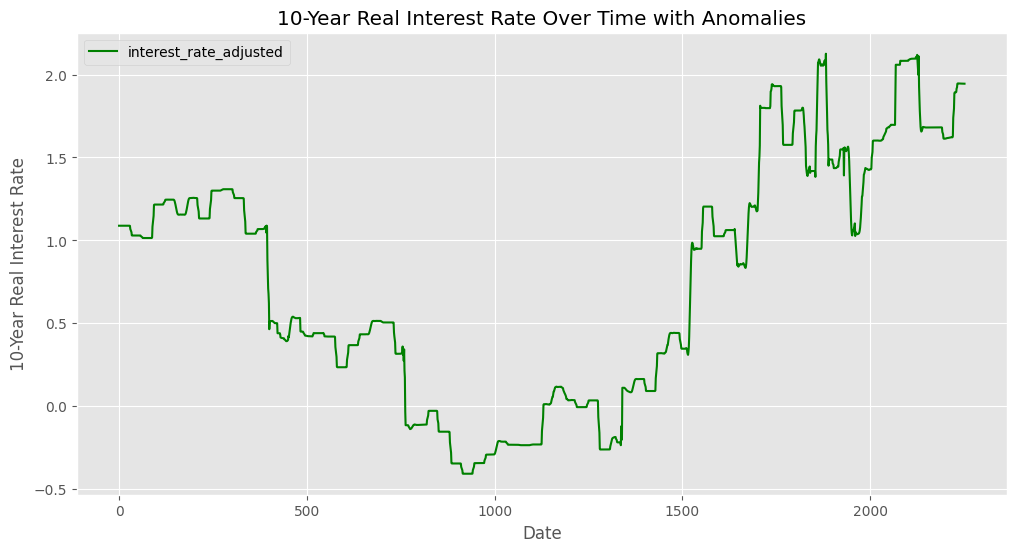

In [44]:
plot_with_anomalies(int_rate_adjusted, 'interest_rate_adjusted', '10-Year Real Interest Rate Over Time with Anomalies', '10-Year Real Interest Rate')

In [101]:
# plot(int_rate_adjusted, 'interest_rate_adjusted')

### Treasury constant maturity

In [46]:
treasure_df_processed, treasure_df_adjusted = load_and_process_seasonal_data(fred.get_series, 'T10Y2Y', 'treasure_maturity')

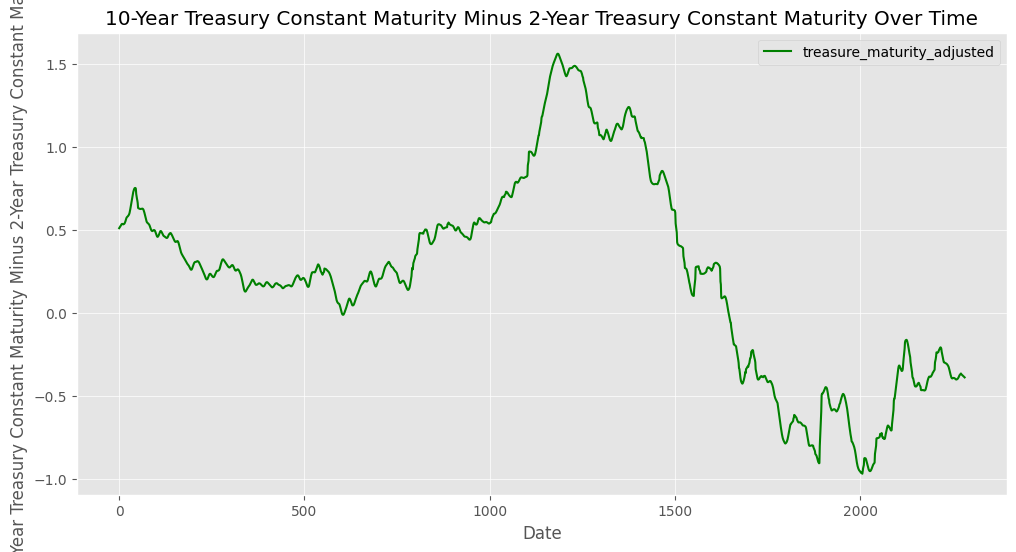

In [47]:
plot_time_series(treasure_df_adjusted, 'treasure_maturity_adjusted', '10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity Over Time', '10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity', color='green')

In [102]:
plot_time_series_plotly(treasure_df_adjusted, 'index', 'treasure_maturity_adjusted', '10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity Over Time')

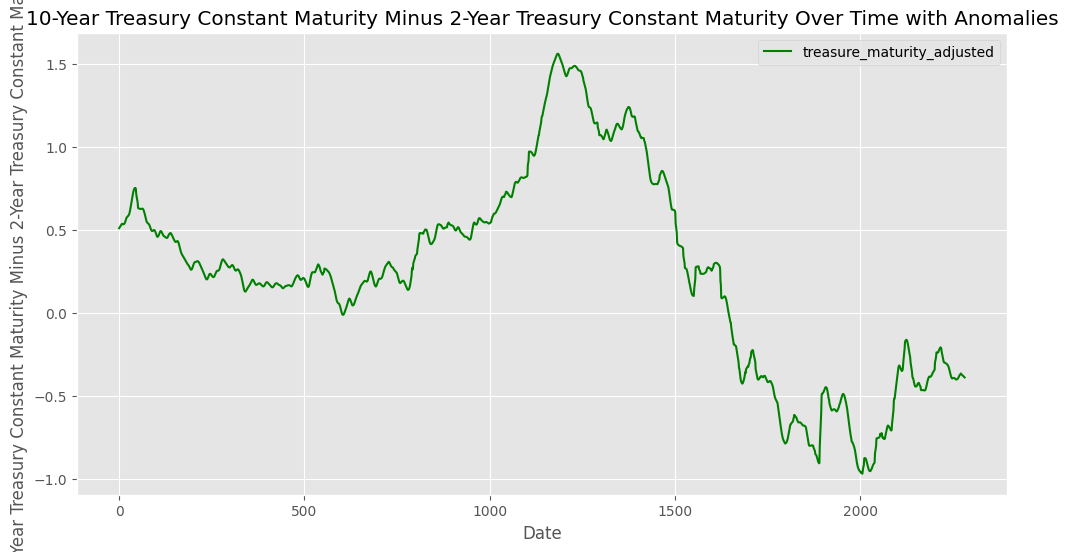

In [49]:
plot_with_anomalies(treasure_df_adjusted, 'treasure_maturity_adjusted', '10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity Over Time with Anomalies', '10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity')

In [103]:
# plot(treasure_df_adjusted, 'treasure_maturity_adjusted')

### Inflation Rate

In [51]:
inflation_rate_processed, inflation_rate_adjusted = load_and_process_seasonal_data(fred.get_series, 'T10YIE', 'inflation_rate')

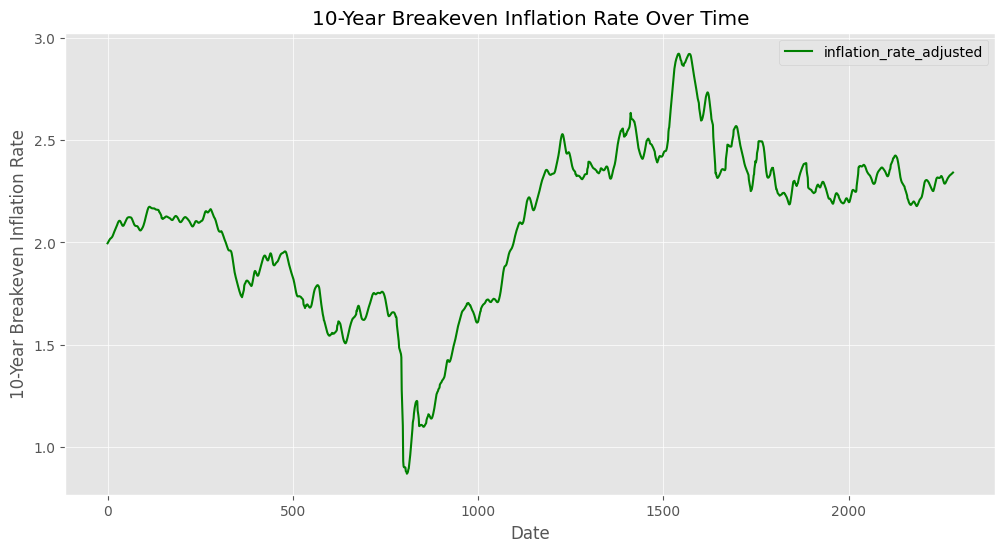

In [52]:
plot_time_series(inflation_rate_adjusted, 'inflation_rate_adjusted', '10-Year Breakeven Inflation Rate Over Time', '10-Year Breakeven Inflation Rate', color='green')

In [104]:
plot_time_series_plotly(inflation_rate_adjusted, 'index', 'inflation_rate_adjusted', '10-Year Breakeven Inflation Rate Over Time')

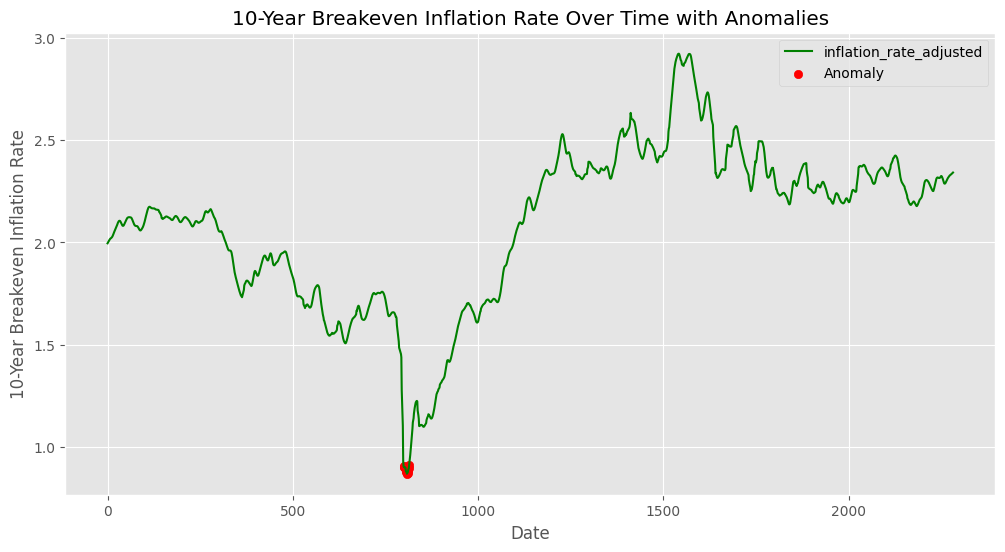

In [54]:
plot_with_anomalies(inflation_rate_adjusted, 'inflation_rate_adjusted', '10-Year Breakeven Inflation Rate Over Time with Anomalies', '10-Year Breakeven Inflation Rate')

In [105]:
# plot(inflation_rate_adjusted, 'inflation_rate_adjusted')

### Sticky Price CPI 

In [56]:
sticky_cpi_df = fred.get_series('CORESTICKM159SFRBATL').to_frame('sticky_cpi').reset_index()
processed_sticky_cpi_df = process_time_series_data(sticky_cpi_df, date_column='index', value_column='sticky_cpi')

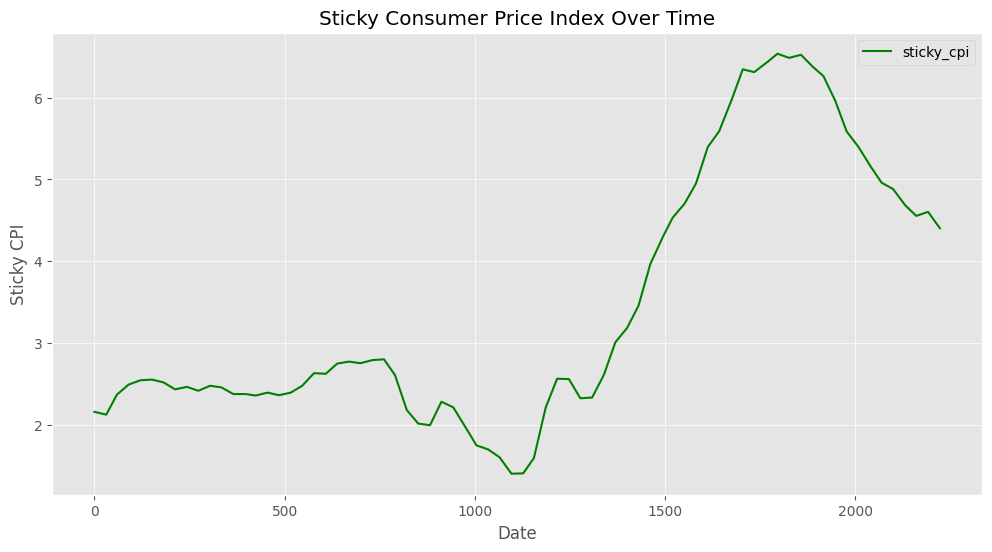

In [57]:
plot_time_series(processed_sticky_cpi_df, 'sticky_cpi', 'Sticky Consumer Price Index Over Time', 'Sticky CPI', color = 'green')

In [106]:
plot_time_series_plotly(processed_sticky_cpi_df, 'index', 'sticky_cpi', 'Sticky Consumer Price Index Over Time')

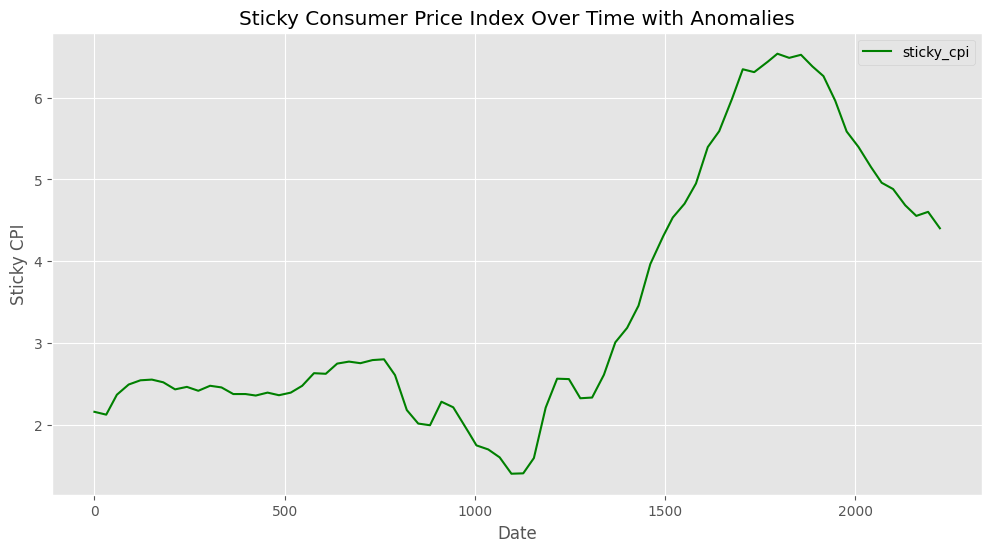

In [59]:
plot_with_anomalies(processed_sticky_cpi_df, 'sticky_cpi', 'Sticky Consumer Price Index Over Time with Anomalies', 'Sticky CPI')

In [107]:
# plot(processed_sticky_cpi_df, 'sticky_cpi')

### M2 Money Stock

In [61]:
m2_money_stock_processed, m2_money_stock_adjusted = load_and_process_seasonal_data(fred.get_series, 'WM2NS', 'm2_money_stock')

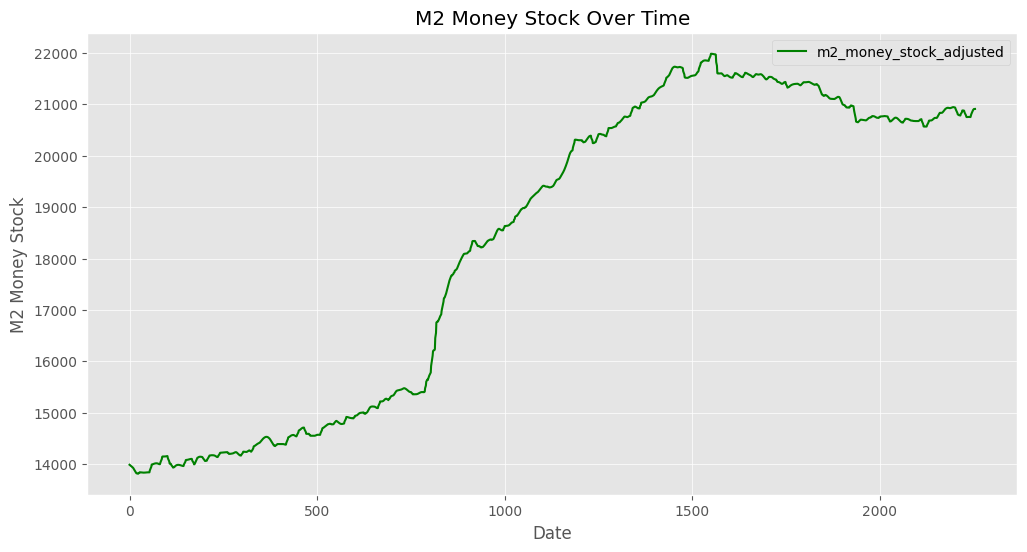

In [62]:
plot_time_series(m2_money_stock_adjusted, 'm2_money_stock_adjusted', 'M2 Money Stock Over Time', 'M2 Money Stock', color='green')

In [108]:
plot_time_series_plotly(m2_money_stock_adjusted, 'index', 'm2_money_stock_adjusted', 'M2 Money Stock Over Time')

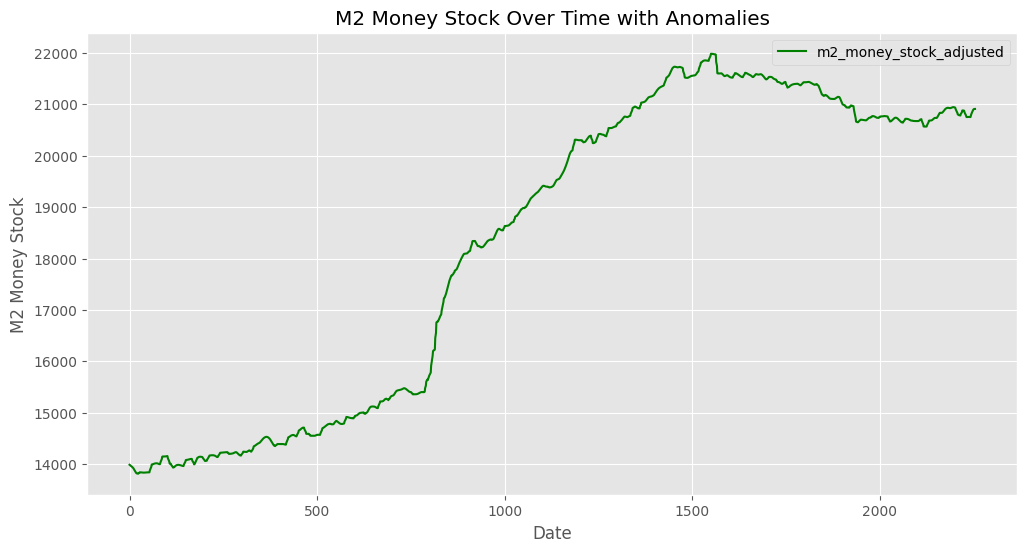

In [64]:
plot_with_anomalies(m2_money_stock_adjusted, 'm2_money_stock_adjusted', 'M2 Money Stock Over Time with Anomalies', 'M2 Money Stock')

In [109]:
# plot(m2_money_stock_adjusted, 'm2_money_stock_adjusted')

## Multivariate Analysis

In [69]:
# List of dataframes to merge
dataframes = [sp500_adjusted, processed_gdp, processed_real_gdp, processed_unrate_df, processed_cpi_df, int_rate_adjusted, treasure_df_adjusted, inflation_rate_adjusted, processed_sticky_cpi_df, m2_money_stock_adjusted]

# Merge dataframes using reduce function
merged_df = reduce(lambda left, right: pd.merge(left, right, on='index', how='outer'), dataframes)

merged_df_processed = merged_df.interpolate(method='pad')


In [110]:
# plot_correlation(merged_df_processed)

In [85]:
report = create_report(merged_df_processed, title='Economic Indicators Report')
#report
# report.save('my_report.html')

  0%|          | 0/2026 [00:00<?, ?it/s]